In [1]:
# %pylab notebook
import numpy as np 
import h5py
import matplotlib.pyplot as plt
# %matplotlib ipympl

In [2]:
G3Xd = h5py.File('./data/G3X-profiles-progenitors_myevoz.hdf5','r')
GIZd = h5py.File('./data/GIZ-profiles-progenitors_myevoz.hdf5','r')

In [10]:
'''
calculate median profiles and percentile error [16,84] statistically

mod: simulation name [GIZMO or GadgetX]
d: simulation data
snap: which snapshot (equally redshift)
region: which property
ntclu: total cluster number (few clusters may not form at high redshift)
part: which particle part (default 0, this is not meaning DM particles)
'''

def cal_median(rbin, value, nbin):
    xmed = np.zeros(nbin)
    ymed = np.zeros(nbin)
    yerr = np.zeros(shape = (2,nbin))
    
    #calculate the median profile
    for j in range(nbin):
#         nonan = np.where((value[:,j]!= 0) & (np.isnan(value[:,j]) == False))[0]
        nonan = np.where((np.isnan(value[:,j]) == False))[0]
        if len(nonan) > 1:
            ymed[j] = np.median(value[nonan,j])
            xmed[j] = np.median(rbin[nonan,j])
            yerrtot = np.percentile(value[nonan,j],[16,84])
            yerr[0,j] = yerrtot[0]
            yerr[1,j] = yerrtot[1]
    return xmed,ymed,yerr

def cal_sta_profiles(mod,d,snap,region,bin25,ntclu,part = 0):
    nbin = 50
    allvalue=np.zeros(shape = (ntclu,nbin))
    rbinvalue=np.zeros(shape = (ntclu,nbin))
    npvalue=np.zeros(shape = (ntclu,nbin))
    
    redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
    Ez = (0.307*(1 + redshift)**3 + 0.693)**0.5
    i = 0
    #read raw data
    for nclu in range(324):
        if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:          
            continue
        M500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['M500']
        T500 = 8.85*(M500 / 1e15 / 0.7)**(2/3) * (0.6125/0.6) * Ez**(2/3) #This 
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
        allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:] /T500
        rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r500 #unit: r/r500
        npvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/NuminBin'%(nclu+1,snap)][0]
        i+=1
    print(i)  
                
    if bin25 == True:
        # combine nearby bins with near 2
        rbin25 = np.zeros(shape = (ntclu, 25))
        value25 = np.zeros(shape = (ntclu, 25))
        np25 = np.zeros(shape = (ntclu, 25))
        for i in range(ntclu):
            for j in range(25):
                bin0 = j*2
                bin1 = j*2+1
                value25[i,j] = (allvalue[i,bin0] + allvalue[i,bin1]) / 2
                rbin25[i,j] = (rbinvalue[i,bin0] + rbinvalue[i,bin1]) / 2
                np25[i,j] = npvalue[i,bin0] + npvalue[i,bin1]
        
        np_med = np.median(np25, axis = 0)
        np25 = np.sum(np25, axis = 1)
        idnp = np.where(np25 >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr = cal_median(rbin25[idnp], value25[idnp], 25)
        return xmed,ymed,yerr,np_med
    else:       
        np_med = np.median(npvalue, axis = 0)
        npvalue = np.sum(npvalue, axis = 1)
        idnp = np.where(npvalue >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr = cal_median(rbinvalue[idnp], allvalue[idnp], 50)
        return xmed,ymed,yerr,np_med

In [7]:
def ob_Temp(ax):
    #-------------------------------------------
    #Ghirardini+2018
    def fvikh(x,A0,A1,A2,A3,A4,A5):
        return A0*(A3+(x/A1)**A4)/(1.+(x/A1)**A4)/(1.+(x/A2)**2.)**A5

    data_multi2=np.loadtxt('./data/ob_MWTemp/T_bfit.dat')
    x=np.exp(np.linspace(np.log(0.01),np.log(2),200))
    t_fitv=np.zeros((len(x),3))
    for i in range(len(x)):
        t_fitv[i,:]=np.percentile(fvikh(x[i],data_multi2[:,0],np.exp(data_multi2[:,1]),data_multi2[:,2],data_multi2[:,3],data_multi2[:,4],data_multi2[:,5]),(16,50,84))

    ob1, = ax.plot(x,t_fitv[:,1], color = 'grey',ls = '-',label = 'Ghirardini+2019 (z < 0.1)', zorder = 2)
    ax.fill_between(x,t_fitv[:,0],t_fitv[:,2],color='grey',alpha=0.5, zorder = 2)
    
    #-------------------------------------------
    #Ghirardini+2021 (highz sample)
    cluid = ['SPT0205','SPT0459','SPT0640','SPT2040','SPT2341']
    cid = ['grey','grey','grey','grey','grey']
    sym = ['o','^','s','d','*']
    for i in range(5):
        m0 = np.loadtxt(open('./data/ob_MWTemp/Ghirardini+2021/%s_m.csv' %cluid[i], 'r'),delimiter = ',')
        l0 = np.loadtxt(open('./data/ob_MWTemp/Ghirardini+2021/%s_l.csv' %cluid[i], 'r'),delimiter = ',')
        r0 = np.loadtxt(open('./data/ob_MWTemp/Ghirardini+2021/%s_r.csv' %cluid[i], 'r'),delimiter = ',')
        u0 = np.loadtxt(open('./data/ob_MWTemp/Ghirardini+2021/%s_u.csv' %cluid[i], 'r'),delimiter = ',')
        d0 = np.loadtxt(open('./data/ob_MWTemp/Ghirardini+2021/%s_d.csv' %cluid[i], 'r'),delimiter = ',')
        xerrl = l0[:,0] - m0[:,0]
        xerrr = m0[:,0] - r0[:,0]
        yerru = u0[:,1] - m0[:,1]
        yerrd = m0[:,1] - d0[:,1]
        if i == 4:
            ob4 = ax.errorbar(m0[:,0],m0[:,1], xerr = [xerrl,xerrr], yerr = [yerrd, yerru], c= cid[i], markersize = 8,
                    capsize = 2, zorder = -1, alpha = 0.45,
                        fmt = sym[i],mfc = 'none', label = 'Ghirardini+2021 (1.2<z<1.7)')
        else:
            ax.errorbar(m0[:,0],m0[:,1], xerr = [xerrl,xerrr], yerr = [yerrd, yerru], c= cid[i], markersize = 8,
                    capsize = 2, zorder = -1, alpha = 0.45, fmt = sym[i],mfc = 'none')   
            
#     #-----------------------------------------------
    #McDonlad+2014
    x0 = np.array([0,0.04,0.08,0.13,0.20,0.28,0.36,0.46,0.58,0.74,0.95,1.2,1.5])
    
    # 0.3 < z < 0.6
    y1 = np.array([1.02,1.04,1.13,1.18,1.17,1.13,1.08,0.99,0.90,0.78,0.67,0.59])
    y1errup = np.array([0.12,0.09,0.06,0.07,0.07,0.06,0.04,0.03,0.03,0.04,0.05,0.07])
    y1errdown = np.array([0.25,0.07,0.08,0.06,0.05,0.04,0.03,0.03,0.03,0.04,0.05,0.05])
    print(x0.shape,y1.shape,y1errdown.shape,y1errup.shape)
    for i in range(12):
        xx = np.linspace(x0[i],x0[i+1],100)
        if i == 0:
            ob2 = ax.fill_between(xx,y1[i] - y1errdown[i], y1[i] + y1errup[i], label = 'McDonald+2014 (0.3<z<0.6)',
                         hatch = '////',color = 'grey', fc = 'none',alpha = 0.4, zorder = -1)
            ob2.set_facecolor('none')
        else:
            sc = ax.fill_between(xx,y1[i] - y1errdown[i], y1[i] + y1errup[i],
                         hatch = '////',color = 'grey', fc = 'none',alpha = 0.4, zorder = -1)
            sc.set_facecolor('none')
    
    # 0.6 < z < 1.2
    y2 = np.array([0.71,0.86,1.04,1.17,1.23,1.21,1.11,0.96,0.83,0.66,0.53,0.44])
    y2errup = np.array([0.08,0.09,0.09,0.14,0.11,0.04,0.04,0.04,0.03,0.04,0.04,0.06])
    y2errdown = np.array([0.08,0.09,0.10,0.06,0.07,0.07,0.03,0.03,0.03,0.02,0.04,0.06])
    for i in range(12):
        xx = np.linspace(x0[i],x0[i+1],100)
        if i == 0:
            ob3 = ax.fill_between(xx,y2[i] - y2errdown[i], y2[i] + y2errup[i], label = 'McDonald+2014 (0.6<z<1.2)',
                         hatch = '\\\\',color = 'grey', facecolors = 'none',alpha = 0.3, zorder = -1)
            ob3.set_facecolor('none')
        else:
            sc = ax.fill_between(xx,y2[i] - y2errdown[i], y2[i] + y2errup[i],
                         hatch = '\\\\',color = 'grey', facecolors = 'none',alpha = 0.3,zorder = -1)
            sc.set_facecolor('none')

    return ob1, ob2, ob3, ob4
# plt.figure()
# ax = plt.gca()
# ob_Temp(ax)
# plt.xlabel(r'$r/r_{500}$')
# plt.ylabel(r'$T/T_{500}$')
# plt.loglog()
# plt.legend(fontsize = 'small')
# # plt.ylim(1e-1,20)
# plt.grid(c = 'grey', ls = '--', alpha = 0.5)
# plt.xlim(1e-2,)
# plt.tight_layout()

# plt.show()

324
input sample is 324
324
input sample is 324
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49]
324
input sample is 324
324
input sample is 324
324
input sample is 324
324
input sample is 324
323
input sample is 323
324
input sample is 324
323
input sample is 323
323
input sample is 323
323
input sample is 317
323
input sample is 302
(13,) (12,) (12,) (12,)


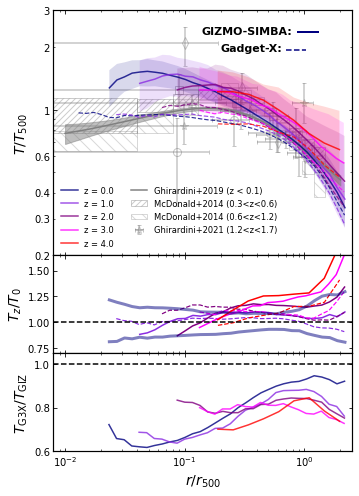

In [15]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,7))
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((9,4),(0,0),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((9,4),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((9,4),(7,0),colspan = 4,rowspan = 2)


snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r','tomato','orange']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
idtGIZ = [37,31,26,21,9,7,7]
idtG3X = [37,33,27,21,8,8,9]
#==========================================================

# GIZMO
for i in [0,1,2,3,4]:
    if i == 0:
        xmed0,ymed0,yerr0,np_med0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWTemp',False,nGIZ[i])
        xmed25,ymed25,yerr25,np_med25 = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWTemp',True,nGIZ[i])
        idt = np.where(np_med0 >= 10)[0]
        print(idt)
        ax1.plot(xmed0[idt],ymed0[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha=0.8)
        ax1.fill_between(xmed0[idt],yerr0[0,idt],yerr0[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed0[idt],yerr0[0,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        ax10.plot(xmed0[idt],yerr0[1,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        
        xmed0_x,ymed0_x,yerr0_x,np_med0_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWTemp',False,nG3X[i])
        xmed25_x,ymed25_x,yerr25_x,np_med25_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWTemp',True,nG3X[i])
        idt_x = np.where(np_med0_x >= 10)[0]
        ax1.plot(xmed0_x[idt_x],ymed0_x[idt_x],lw = 1.2, ls = '--',  c=colall[i], zorder = 30,alpha = 0.8)
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed0_x[idt],ymed0_x[idt]/ymed0[idt], c=colall[i], zorder = 30,alpha = 0.8)
        
    elif i <= 3:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWTemp',False,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed0[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWTemp',False,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed0_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
        
    else:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWTemp',True,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color =colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed25[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWTemp',True,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed25_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
    

ax1.text(0.138,2.3,'GIZMO-SIMBA:',weight = 'bold',size = 11) 
ax1.text(0.2,1.9,'Gadget-X:',weight = 'bold',size = 11) 

from matplotlib.lines import Line2D
lin1 = Line2D([],[],c = 'navy',lw = 2)
legend2 = ax1.legend(handles=[lin1],frameon = False, loc = (0.805,0.875))
ax1.add_artist(legend2)

lin0 = Line2D([],[],c = 'navy',lw = 1.5, ls = '--')
legend0 = ax1.legend(handles=[lin0],frameon = False, loc = (0.765,0.80))
ax1.add_artist(legend0)



ob1, ob2, ob3, ob4 = ob_Temp(ax1)
# legend_ob = ax1.legend(handles=[ob1,ob2,ob3,ob4],frameon = False, loc = (0.765,0.20))
# ax1.add_artist(legend_ob)
#==========================================================================
# ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='k',ls='--')

ax1.set_ylabel(r'$T/T_{500}$',fontsize = 14)
ax1.loglog()
ax1.set_xticklabels([])
ax1.set_ylim(2e-1,3)
ax1.set_xlim(0.008,2.5)
# ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,2.5)
# ax10.set_xlabel(r'$r/r_{500}$',fontsize = 14)
ax10.set_ylabel(r'$T_z/T_0$',fontsize = 14)
ax10.set_ylim(0.7,1.65)
# ax10.set_yticks([0.5,1,1.5])
# ax10.set_yticklabels([0.5,1,1.5])
ax1.legend(fontsize = 'small', ncol = 2, loc = 3, frameon = False)
ax1.set_yticks([1])
ax1.set_yticklabels(['1'])
ax1.set_yticks([0.2,0.3,0.4,0.6,2,3],minor = True)
ax1.set_yticklabels(['0.2','0.3','0.4','0.6','2','3'],minor = True)
ax1.set_yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3],minor = True)

ax20.axhline(1,c='k',ls='--')
ax20.set_xscale('log')
ax20.set_xlim(0.008,2.5)
ax20.set_ylim(0.6,1.05)
ax20.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax20.set_ylabel(r'$T_{\rm G3X}/T_{\rm GIZ}$', fontsize = 14)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

ax1.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
ax10.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
plt.tight_layout()
plt.subplots_adjust(wspace =0, hspace = 0)
plt.savefig('./figsv2/MWTemp.pdf')


In [ ]:
def ob_temp():
    #-------------------------------------------
    #Ghirardini+2018
    def fvikh(x,A0,A1,A2,A3,A4,A5):
        return A0*(A3+(x/A1)**A4)/(1.+(x/A1)**A4)/(1.+(x/A2)**2.)**A5

    data_multi2=np.loadtxt('./data/ob_MWTemp/T_bfit.dat')
    x=np.exp(np.linspace(np.log(0.01),np.log(2),200))
    t_fitv=np.zeros((len(x),3))
    for i in range(len(x)):
        t_fitv[i,:]=np.percentile(fvikh(x[i],data_multi2[:,0],np.exp(data_multi2[:,1]),data_multi2[:,2],data_multi2[:,3],data_multi2[:,4],data_multi2[:,5]),(16,50,84))

    plt.plot(x,t_fitv[:,1],'k--',label = 'Ghirardini + 2018 (z < 0.1)')
    plt.fill_between(x,t_fitv[:,0],t_fitv[:,2],color='k',alpha=0.3)
    
#     #------------------------------------------
#     #Keruzore+2020
#     K_middle = np.loadtxt(open('./data/ob_MWTemp/Keruzore_middle.csv', 'r'),delimiter = ',')
#     K_up = np.loadtxt(open('./data/ob_MWTemp/Keruzore_up.csv', 'r'),delimiter = ',')
#     K_down = np.loadtxt(open('./data/ob_MWTemp/Keruzore_down.csv', 'r'),delimiter = ',')
#     redshift = 0.865
#     Ez = (0.30*(1 + redshift)**3 + 0.7)**0.5
#     M500 = 2.48e14 * 0.7 #Msun/h
#     r500 = 780.9 #kpc
#     T500 = 8.85*(M500 / 1e15 / 0.7)**(2/3) * (0.6125/0.6) * Ez**(2/3) #This 
#     errup = (K_up[:,1] - K_middle[:,1])/T500
#     errdown = (K_middle[:,1] - K_down[:,1])/T500
#     plt.errorbar(K_middle[:,0]/r500,K_middle[:,1]/T500,yerr = [errdown, errup], 
#                  c = 'orange',fmt = '^',mfc = 'none', label = 'Keruzore+2020 (z=0.865)'
#                  ,ms = 5, zorder = 20, capsize = 2)
    
    #-------------------------------------------
    #Ruppin+2020b
    R2020b = np.loadtxt(open('./data/ob_MWTemp/Ruppin+2020b.csv', 'r'),delimiter = ',')
    redshift = 1.2
    Ez = (0.30*(1 + redshift)**3 + 0.7)**0.5
    M500 = 6.06e14 * 0.6777 #Msun/h
    r500 = 790 #kpc
    T500 = 8.85*(M500 / 1e15 / 0.7)**(2/3) * (0.6125/0.6) * Ez**(2/3) #This 
    plt.plot(R2020b[:,0]/r500,R2020b[:,1]/T500,c = 'cyan',lw = 2, ls = '--', zorder = 100,
             label = 'Ruppin+2020(z=1.2)')
    
    #--------------------------------------------
    #Balid+2012
    def V2006(xx,A,a,alpha0,ep0,b,beta0):
        a1 = ((xx/a)**alpha0 + ep0)/((xx/a)**alpha0 + 1)
        a2 = 1 / (1 + (xx/b)**2)**beta0
        return A*a1*a2
    xx = np.logspace(-2,0,100)
    yy = V2006(xx,A = 1.35,a = 0.045,alpha0 = 1.9,ep0 = 0.45,b = 0.6,beta0 = 0.45)
    plt.plot(xx,yy,c = 'pink',zorder = 100, lw = 2, ls = '--', label = 'Balid+2012(0.4<z<0.9)')
    
    #-------------------------------------------
    #Ghirardini+2021 (highz sample)
    cluid = ['SPT0205','SPT0459','SPT0640','SPT2040','SPT2341']
    cid = ['r','lime','deepskyblue','purple','magenta']
    for i in range(5):
        m0 = np.loadtxt(open('./data/ob_MWTemp/Ghirardini+2021/%s_m.csv' %cluid[i], 'r'),delimiter = ',')
        l0 = np.loadtxt(open('./data/ob_MWTemp/Ghirardini+2021/%s_l.csv' %cluid[i], 'r'),delimiter = ',')
        r0 = np.loadtxt(open('./data/ob_MWTemp/Ghirardini+2021/%s_r.csv' %cluid[i], 'r'),delimiter = ',')
        u0 = np.loadtxt(open('./data/ob_MWTemp/Ghirardini+2021/%s_u.csv' %cluid[i], 'r'),delimiter = ',')
        d0 = np.loadtxt(open('./data/ob_MWTemp/Ghirardini+2021/%s_d.csv' %cluid[i], 'r'),delimiter = ',')
        xerrl = l0[:,0] - m0[:,0]
        xerrr = m0[:,0] - r0[:,0]
        yerru = u0[:,1] - m0[:,1]
        yerrd = m0[:,1] - d0[:,1]
        if i == 4:
            plt.errorbar(m0[:,0],m0[:,1], xerr = [xerrl,xerrr], yerr = [yerrd, yerru], c= cid[i],
                    capsize = 2, zorder = 30, fmt = 'o',mfc = 'none', label = 'Ghirardini+2021 (1.2<z<1.7)')
        else:
            plt.errorbar(m0[:,0],m0[:,1], xerr = [xerrl,xerrr], yerr = [yerrd, yerru], c= cid[i],
                    capsize = 2, zorder = 30, fmt = 'o',mfc = 'none')   
            
    #-----------------------------------------------
    #McDonlad+2014
    x0 = np.array([0,0.04,0.08,0.13,0.20,0.28,0.36,0.46,0.58,0.74,0.95,1.2,1.5])
    
    # 0.3 < z < 0.6
    y1 = np.array([1.02,1.04,1.13,1.18,1.17,1.13,1.08,0.99,0.90,0.78,0.67,0.59])
    y1errup = np.array([0.12,0.09,0.06,0.07,0.07,0.06,0.04,0.03,0.03,0.04,0.05,0.07])
    y1errdown = np.array([0.25,0.07,0.08,0.06,0.05,0.04,0.03,0.03,0.03,0.04,0.05,0.05])
    print(x0.shape,y1.shape,y1errdown.shape,y1errup.shape)
    for i in range(12):
        xx = np.linspace(x0[i],x0[i+1],100)
        if i == 0:
            sc = plt.fill_between(xx,y1[i] - y1errdown[i], y1[i] + y1errup[i], label = 'McDonald+2014 (0.3<z<0.6)',
                         hatch = '////',color = 'r', fc = 'none',alpha = 0.8, zorder = 100)
            sc.set_facecolor('none')
        else:
            sc = plt.fill_between(xx,y1[i] - y1errdown[i], y1[i] + y1errup[i],
                         hatch = '////',color = 'r', fc = 'none',alpha = 0.8, zorder = 100)
            sc.set_facecolor('none')
    
    # 0.6 < z < 1.2
    y2 = np.array([0.71,0.86,1.04,1.17,1.23,1.21,1.11,0.96,0.83,0.66,0.53,0.44])
    y2errup = np.array([0.08,0.09,0.09,0.14,0.11,0.04,0.04,0.04,0.03,0.04,0.04,0.06])
    y2errdown = np.array([0.08,0.09,0.10,0.06,0.07,0.07,0.03,0.03,0.03,0.02,0.04,0.06])
    for i in range(12):
        xx = np.linspace(x0[i],x0[i+1],100)
        if i == 0:
            sc = plt.fill_between(xx,y2[i] - y2errdown[i], y2[i] + y2errup[i], label = 'McDonald+2014 (0.6<z<1.2)',
                         hatch = '\\\\',color = 'b', facecolors = 'none',alpha = 0.8, zorder = 100)
            sc.set_facecolor('none')
        else:
            sc = plt.fill_between(xx,y2[i] - y2errdown[i], y2[i] + y2errup[i],
                         hatch = '\\\\',color = 'b', facecolors = 'none',alpha = 0.8, zorder = 100)
            sc.set_facecolor('none')
    
plt.figure()
ob_temp()
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$T/T_{500}$')
plt.loglog()
plt.legend(fontsize = 'small')
# plt.ylim(1e-1,20)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)
plt.xlim(1e-2,)
plt.tight_layout()
# ax = plt.gca()
# ax.set_yticks([0.2, 0.4, 0.6, 2 ], minor = True)
# ax.set_yticklabels( labels = [], minor = True)
# ax.set_yticks([1 ])
# ax.set_yticklabels( labels = [])

plt.show()

<IPython.core.display.Javascript object>


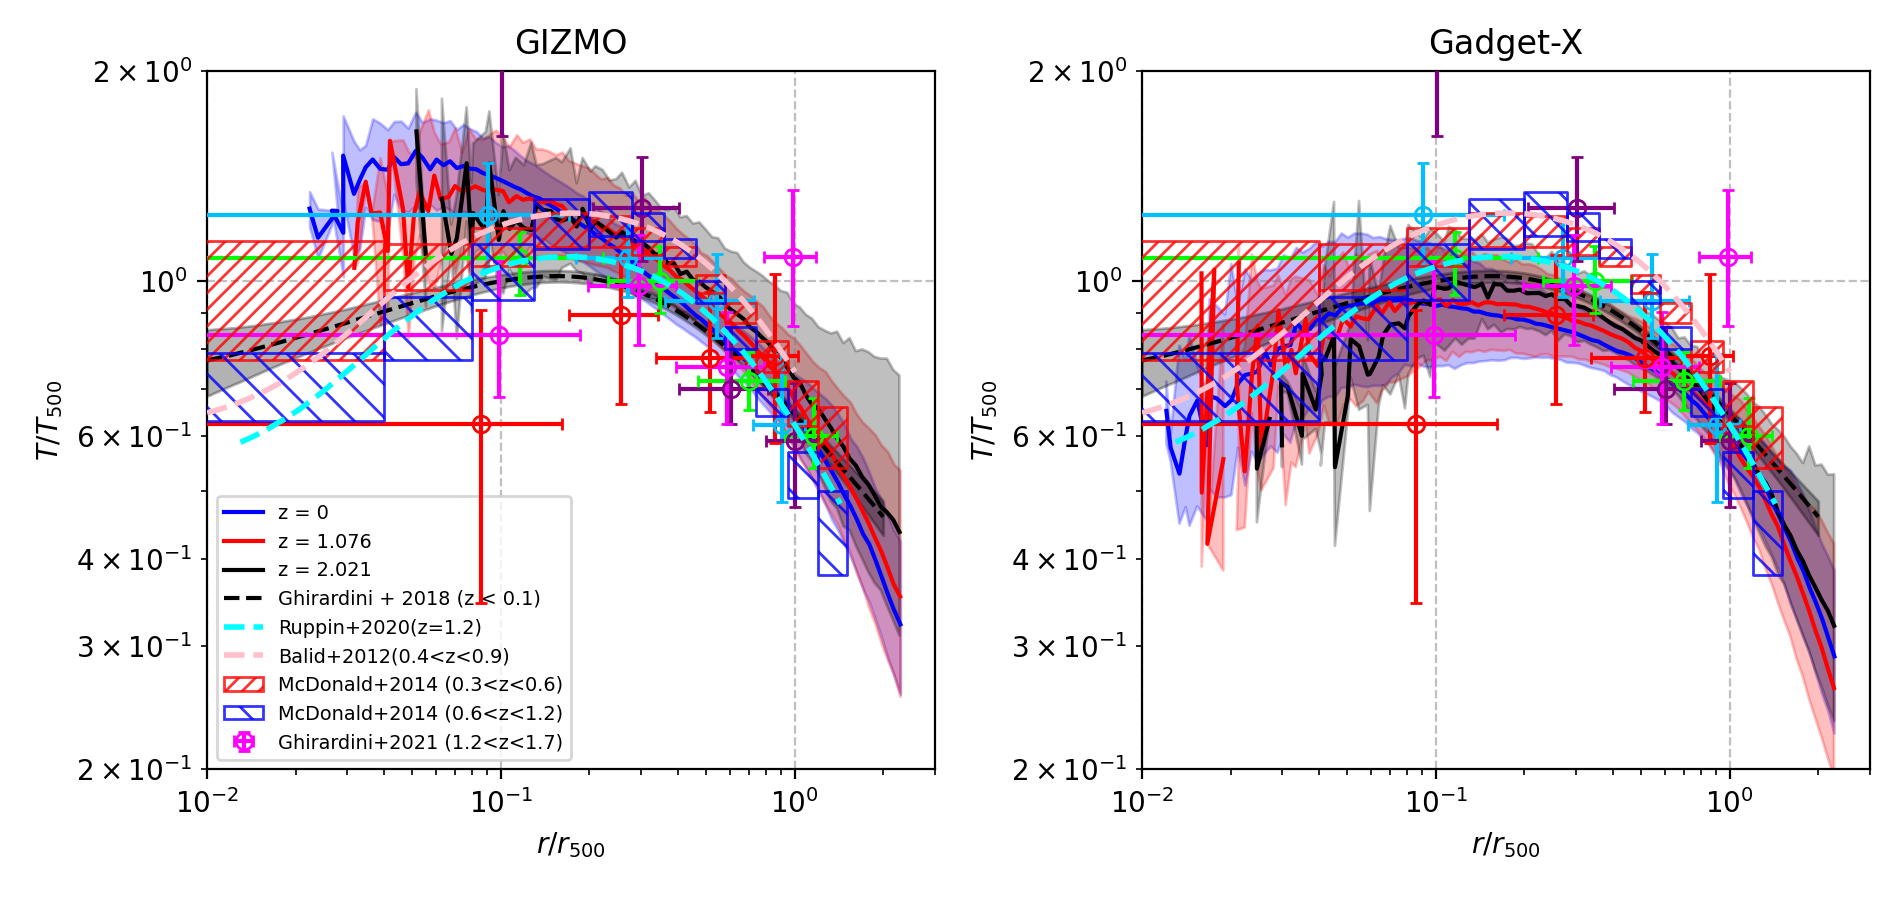

324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(13,) (12,) (12,) (12,)
324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(13,) (12,) (12,) (12,)


In [14]:
#temperature

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

plt.figure(figsize = (9.5,4.5))
plt.subplot(121)

#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'MWTemp',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'MWTemp',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'MWTemp',323)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

ob_temp()

plt.title('GIZMO')
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$T/T_{500}$')
# plt.ylabel(r'$T[keV]$')
plt.loglog()
plt.legend(fontsize = 'x-small')
plt.ylim(2e-1,2)
plt.xlim(1e-2,3)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

plt.subplot(122)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,128,'MWTemp',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,95,'MWTemp',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,78,'MWTemp',324)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

ob_temp()
plt.title('Gadget-X')
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$T/T_{500}$')
# plt.ylabel(r'$T[keV]$')
plt.loglog()
plt.ylim(2e-1,2)
plt.xlim(1e-2,3)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

plt.tight_layout()

<IPython.core.display.Javascript object>


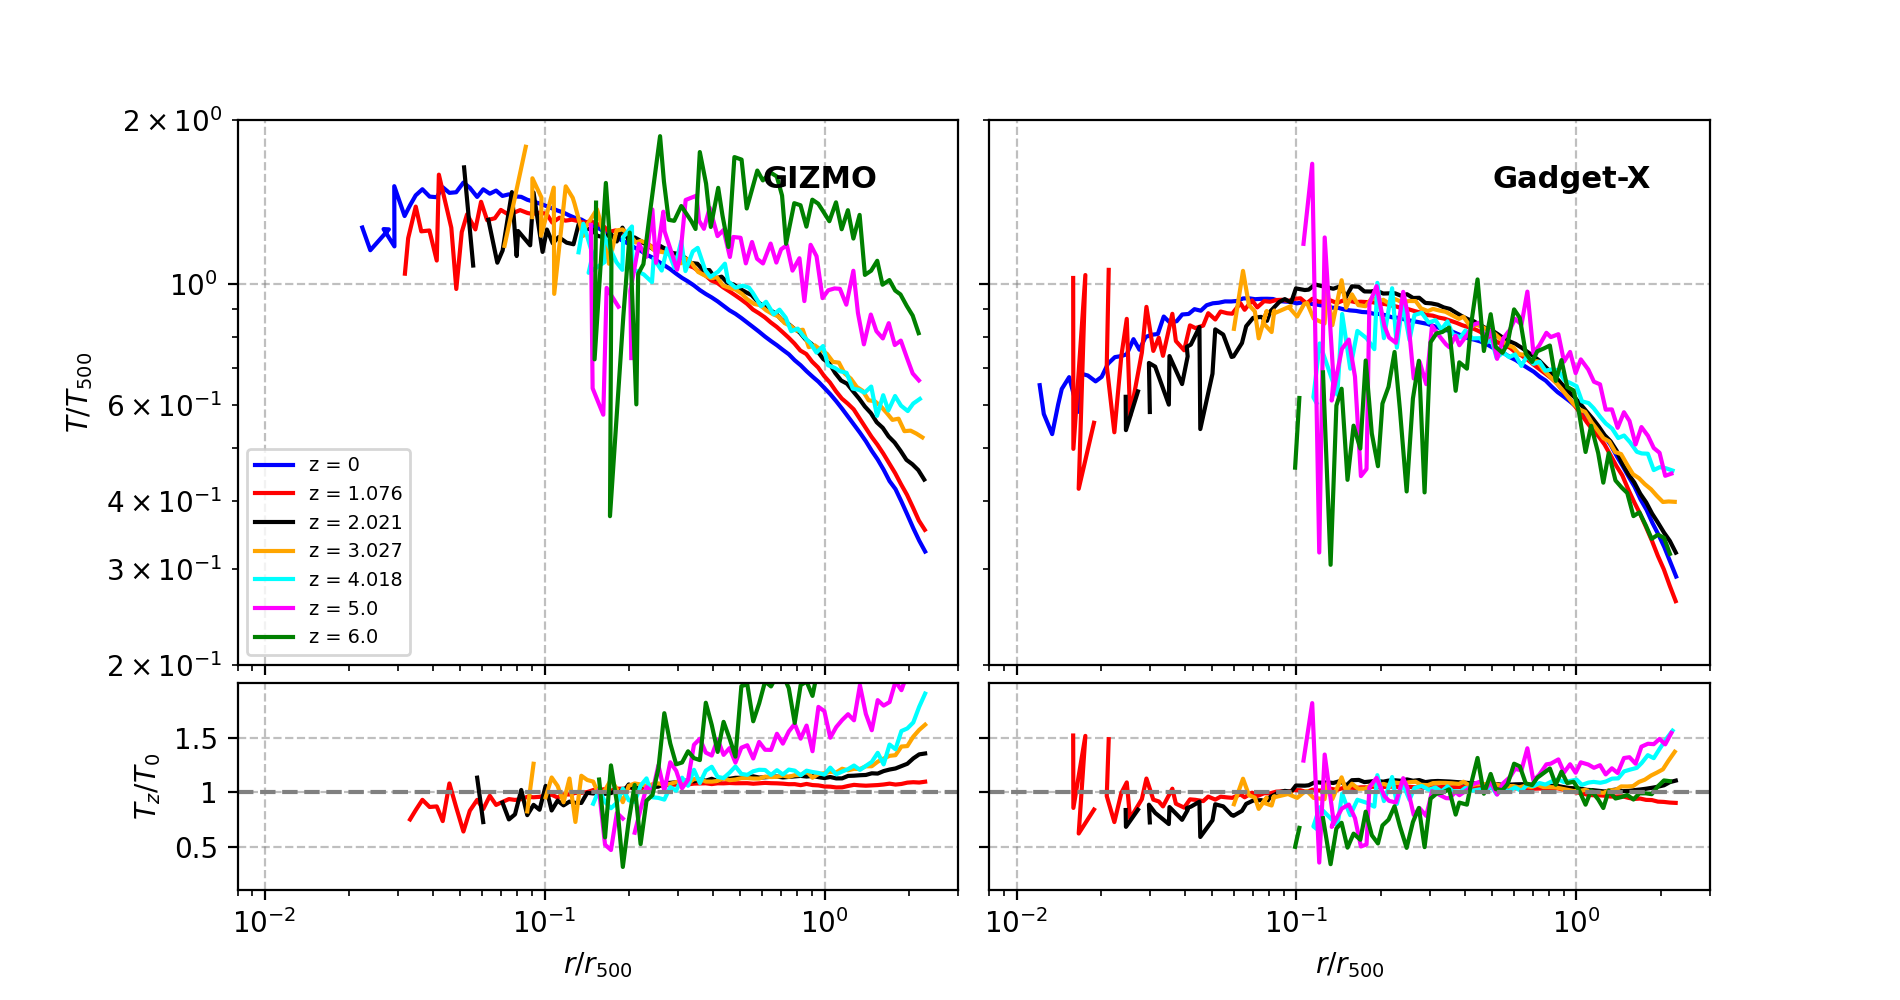

324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


318


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


306


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


320


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


305


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

In [12]:
#study evolution of temperature
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (9.5,5))
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((7,8),(0,0),colspan = 4,rowspan = 5)
ax2 = plt.subplot2grid((7,8),(0,4),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((7,8),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((7,8),(5,4),colspan = 4,rowspan = 2)

snapb = [128,95,78,65,55,47,40]
redb = ['z = 0','z = 1.076','z = 2.021','z = 3.027','z = 4.018','z = 5.0','z = 6.0']
colall = ['b','r','k','orange','cyan','magenta','g']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWTemp',nGIZ[i])
        ax1.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWTemp',nGIZ[i])
        ax1.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax10.plot(xmed0,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='grey',ls='--')

ax1.text(0.6,1.5,'GIZMO',weight = 'bold',size = 11)
ax1.set_ylabel(r'$T/T_{500}$')
ax1.loglog()
ax1.legend(fontsize = 'x-small', loc = 3)
ax1.axes.xaxis.set_ticklabels([])
ax1.set_ylim(2e-1,2)
ax1.set_xlim(0.008,3)
ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,3)
ax10.set_ylim(0.1,2)
ax10.set_xlabel(r'$r/r_{500}$')
ax10.set_ylabel(r'$T_z/T_0$')
ax10.set_yticks([0.5,1,1.5])
ax10.set_yticklabels([0.5,1,1.5])

#Gadget-X
for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWTemp',nG3X[i])
        ax2.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWTemp',nG3X[i])
        ax2.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax20.plot(xmed,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax20.grid(c = 'grey', ls = '--', alpha = 0.5)
ax20.axhline(1,c='grey',ls='--')
ax2.text(0.5,1.5,'Gadget-X',weight = 'bold',size = 11)

ax2.grid(c = 'grey', ls = '--', alpha = 0.5)
ax2.axes.xaxis.set_ticklabels([])
ax2.set_ylim(2e-1,2e0)
ax2.set_xlim(0.008,3)
ax2.loglog()
ax2.set_yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2], minor = True)
ax2.set_yticklabels( labels = [], minor = True)
ax2.set_yticks([1 ])
ax2.set_yticklabels( labels = [])

ax20.set_xscale('log')
ax20.set_xlim(0.008,3)
ax20.set_ylim(0.1,2)
ax20.set_xlabel(r'$r/r_{500}$')
ax20.set_yticks([0.5,1,1.5])
ax20.set_yticklabels([])

# plt.savefig('./figs/Gdens.pdf')
# plt.tight_layout()

<IPython.core.display.Javascript object>


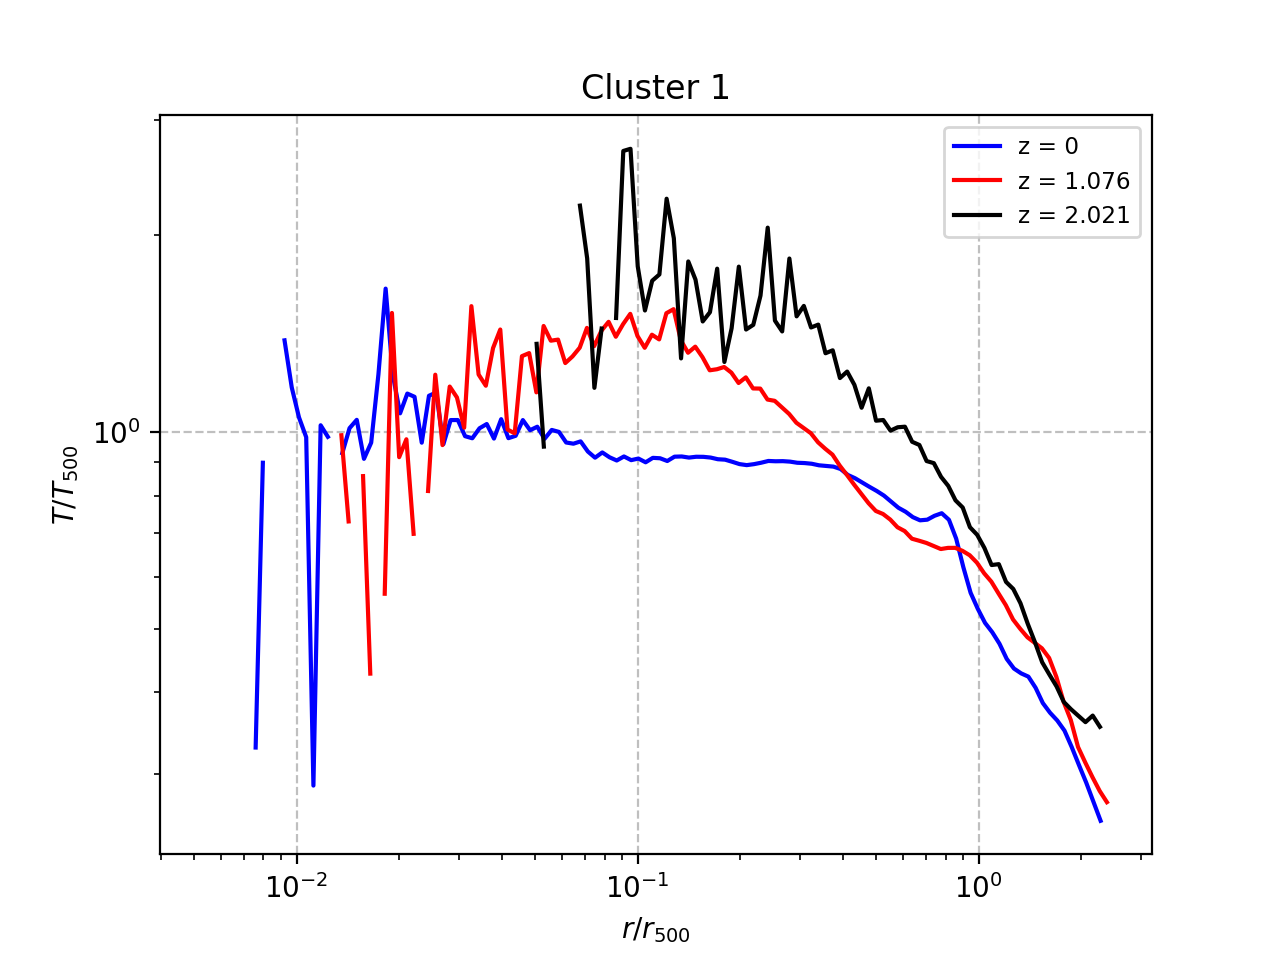

1757948750000000.0
170002968750000.0
17849001464843.75


In [33]:
plt.figure()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

def cal_one_profiles(mod,d,snap,region,pty,nclu):
    nbin = 150
    allvalue=np.zeros(shape = (nbin))
    rbinvalue=np.zeros(shape = (nbin))
    npvalue=np.zeros(shape = (nbin))
    redshift = d['NewMDCLUSTER_0001_%s/snap_%03d'%(pty,snap)].attrs['redshift']
    Ez = (0.307*(1 + redshift)**3 + 0.693)**0.5
    
    M500 = d['NewMDCLUSTER_%04d_%s/snap_%03d'%(nclu+1,pty,snap)].attrs['M500']
    print(M500)
    T500 = 8.85*(M500 / 1e15 / 0.7)**(2/3) * (0.6125/0.6) * Ez**(2/3) #This 

    r500 = d['NewMDCLUSTER_%04d_%s/snap_%03d'%(nclu+1,pty,snap)].attrs['r500']
    allvalue = d['NewMDCLUSTER_%04d_%s/snap_%03d/%s'%(nclu+1,pty,snap,region)][:] / T500
    rbinvalue = d['NewMDCLUSTER_%04d_%s/snap_%03d/Rbin'%(nclu+1,pty,snap)][:] / r500 #unit: r/r500      
    return rbinvalue,allvalue

GIZd = h5py.File('./data/test/GIZ-profiles-evoz_clu1.hdf5','r')

xmed,ymed = cal_one_profiles('GIZ',GIZd,128,'MWTemp','delaytime',nclu = 0)
plt.plot(xmed,ymed,c='b',label = 'z = 0')

#z = 1.076
xmed,ymed = cal_one_profiles('GIZ',GIZd,95,'MWTemp','delaytime',nclu = 0)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')

#z = 2.021
xmed,ymed = cal_one_profiles('GIZ',GIZd,78,'MWTemp','delaytime',nclu = 0)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')

#--------------------------------------------
# xmed,ymed = cal_one_profiles('GIZ',GIZd,128,'MWTemp','nowind',nclu = 0)
# plt.plot(xmed,ymed,c='b',label = 'z = 0 (no wind)',ls = '--')

# #z = 1.076
# xmed,ymed = cal_one_profiles('GIZ',GIZd,95,'MWTemp','nowind',nclu = 0)
# plt.plot(xmed,ymed,c='r',label = 'z = 1.076 (no wind)',ls = '--')

# #z = 2.021
# xmed,ymed = cal_one_profiles('GIZ',GIZd,78,'MWTemp','nowind',nclu = 0)
# plt.plot(xmed,ymed,c='k',label = 'z = 2.021 (no wind)', ls = '--')
GIZd.close()
# #--------------------------------------------
plt.title('Cluster 1')
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$T/T_{500}$')
plt.loglog()
plt.legend(fontsize = 'small')
# plt.ylim(1e-1,2)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(13,) (12,) (12,) (12,)
324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


318


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


306


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


320


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


305


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
